# Steady One-Dimensional Spray Combustion

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 10 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 21 February 2020.

The objectives of this tutorial are to show how to implement and solve a system of coupled nonlinear ordinary differential equations plus ancillary equations using Cantera, where the equations correspond to a simplified model for steady one-dimensional spray combustion. The model is exercised to illustrate key trends. We will use the thermodynamic properties and molecular transport properties that are included in seiser.cti.

The file "seiser.cti" must be placed in a folder or directory named "data" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place. The .cti file is also available at https://github.com/Cantera/cantera-jupyter/tree/master/reactors/data.

The reader should be familiar with the material in Chapter 9 Notebooks before working through this Notebook.

## 1. Model description

The model is developed at the end of Chapter 10 of Turns 4th ed. The key simplifications/assumptions are given there. In particular, it is assumed that the local gas temperature and composition at any spatial location $x$ are the values corresponding to the local equilibrium values (equilibrium for given mixture enthalpy and pressure) at that location. Therefore, we do not need a reaction mechanism, but we do need thermodynamic properties for both the liquid fuel and the gas-phase mixture, and transport properties for the gas-phase mixture; the latter are needed to compute the fuel vaporization rate. All fuel properties are constant in this model, and the liquid fuel temperature is equal to the boiling temperature. 

In Section 3 below, we set up and solve the problem that is posed in Example 10.5 of Turns 4th ed. In the problem statement, an "initial temperature" (denoted as $ T_{r0} $ in the following) is given, and two equivalence ratios are given: an "overall equivalence ratio" ($ \Phi _ {OA} $) and a "premixed equivalence ratio" ($ \Phi _ {g0} $). These quantities are used as follows to set the initial conditions (at $x=0$) for the problem.

* The given initial temperature $ T_{r0} $ corresponds to the temperature of a fuel/oxidizer reactant mixture at the given value of the premixed equivalence ratio. Because we assume that the gas-phase combustion is infinitely fast, the $x=0$ gas temperature ($T_{g0}$) is *not* equal to $ T_{r0} $; rather, $T_{g0}$ is the equilibrium temperature corresponding to a fuel/oxidizer mixture at the given initial temperature $ T_{r0} $ and the given premixed equivalence ratio $ \Phi _ {g0} $.

* The "overall equivalence ratio" $ \Phi _ {OA} $ is an equivalence ratio that accounts for both the liquid fuel and the vapor fuel. As the liquid fuel droplets vaporize, the local gas-phase equivalence ratio increases. If all of the liquid fuel were to vaporize completely, the gas-phase equivalence ratio would then be equal to $ \Phi _ {OA} $.

* All of the oxidizer enters the system in the gas phase at $ x = 0 $. The term $ \dot m_a ' $ in Turns Chapter 10 is equal to zero.

* The initial ($x=0$) liquid fuel mass flow rate ($ \dot m _ {l0} $) can be calculated directly from the known values of the liquid mass density $ \rho _ l $ (= constant), the initial droplet velocity $v_{d0}$, and the total fuel injection area $A_{inj}$ as $ \dot m _ {l0} = \rho _ l v_{d0} A_{inj} $.

* The stoichiometric fuel/oxidizer mass rate ($(F/O)_{stoich}$) can be computed in the usual way (see Chapter 2 of Turns 4th ed.) from the given fuel (here n-heptane) and oxidizer (here pure $O_2$) compositions.

The following relationships then pertain among the oxidizer mass flow rate $ \dot m _ a $, the vapor fuel mass flow rate $ \dot m _ F $, the gas mass flow rate $ \dot m _ g $, and the liquid mass flow rate $ \dot m _ l $ (all in kg/s). Here a subscript $0$ denotes an initial ($x=0$) value of that quantity:

$$ \dot m _ a = constant $$
$$ \dot m_ F = \dot m _ F (x) \ , \ \dot m_ g = \dot m _ g (x) \ , \ \dot m_ l = \dot m _ l (x) $$
$$ \frac{\dot m _ {l0} + \dot m _ {F0}}{\dot m _ a} = \Phi_{OA} ( F/O )_{stoich} $$
$$ \frac{\dot m _ {F0}}{\dot m _ a} = \Phi_{g0} ( F/O )_{stoich} $$

From these expressions, the initial ($x=0$) mass flow rates can all be determined.

Further information can be found in the comments in Sections 2 and 3 below.

## 2. Cantera implementation

No standard predefined Cantera object is available for this system. Therefore, as was the case in Cantera tutorial Notebook 4_1_ODE_integration_thermal_NO, we will explicitly code the system of nonlinear coupled ordinary differential equations (ODEs) and ancillary algebraic equations that must be solved, and we will solve them using [`solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

Here the gas-phase mixture thermodynamic and transport properties that are needed will be taken from a Cantera input data file, rather than using the Appendix B curvefits. In the equilibrium calculations, full equilibrium will be computed using all of the species that are considered in the gas-phase input data file, rather than considering only the major species. And while the (here constant) liquid fuel properties could in principle be taken from an appropriate Cantera input data file, here we will specify the necessary properties directly for the fuel of interest (n-heptane). 

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
import time

# print Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define an ideal-gas mixture using thermodynamic and transport property data from seiser.cti
gas = ct.Solution('data/seiser.cti')

# define a flame object, so that transport properties can be accessed - see tutorial Notebook
#   7_1_Molecular_transport_properties
flame = ct.FreeFlame(gas)



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


In [3]:
# print the temperature range over which the property data are intended to be used
gas.min_temp, gas.max_temp

(300.0, 3000.0)

In Section 3 below, we will use the property data at temperatures greater than 3000 K, so that we can compare our results with those given in Chapter 10 of Turns 4th ed. This is one contributor to the differences that we will see and discuss there.

Now let's set up our Cantera model. A glossary of key variables that we will use follows:

In [4]:
# independent variable
#   x - spatial coordinate (m)

# dependent variables for which ODEs are solved (functions of x)
#   D      - liquid droplet diameter (m)
#   mdot_g - gas-phase mass flow rate (kg/s)
#   h_g    - gas-phase enthalpy (J/kg)
#   v_d    - liquid droplet speed (m/s)

# other principal dependent variables (functions of x)
#   v_g    - gas-phase flow speed (m/s)
#   Phi_g  - gas-phase equivalence ratio (-)
#   mdot_l - liquid mass flow rate (kg/s)

# given as a function of x
# here we consider the case where mdot_a remains constant at its x=0 value: there is no additional oxidizer injection
#   downstream of the combustor inlet
#   mdot_a - oxidizer mass flow rate (kg/s)

# local gas-phase mean properties that are needed to compute vaporization rate
#   c_pg  - mean constant-pressure specific heat (J/kg-K)
#   k_g   - mean thermal conductivity (W/m-K)

# other local gas-phase properties that are needed
#   rho_g - mass density (kg/m^3)
#   T_g   - temperature (K)
#   mu_g  - dynamic viscosity (Pa-s)

# other local quantities that are needed
#   K         - burning-rate constant (m^2/s)
#   C_D       - droplet drag coefficient (-)
#   dmdot_gdx - spatial derivative of mdot_g (kg/m-s)
#   dmdot_ldx - spatial derivative of mdot_l (kg/m-s)

# number of droplets per second (a constant, deduced from the initial conditions)
#   Ndot - number of droplets per second (droplets/s)

# fuel and oxidizer (given and constant)
#   fuel      - fuel composition
#   oxid      - oxidizer composition
#   FO_stoich - stoichiometric fuel/oxidizer mass ratio (-)

# liquid fuel properties (given and constant)
#   T_l   - liquid temperature = boiling temperature of the liquid at the given pressure (K)
#   rho_l - liquid density (kg/m^3)
#   h_fg  - heat of vaporization (J/kg)
#   h_l   - enthalpy (J/kg)

# operating pressure (given and constant)
#   P     - pressure (Pa)

# overall combustor dimensions (given and constant)
#   A - cross-secional area (m^2)
#   L - length (m)

# for initial conditions at x=0, append a subscript 0 to the corresponding variable name

Several functions are defined to compute key quantities that are needed to solve the governing equations:

In [5]:
# define a function that computes the necessary gas-phase mixture properties, using Eqs. 10.21-10.23 of Turns 4th ed.
#   to compute appropriate mean values
# the mixture pressure is constant
# local variable names are used in the function to avoid potential conflicts with external variable names
# function input arguments:
#   gasl is the gas-phase mixture, whose temperature, pressure, and composition on calling this function are the current
#     gas-phase (subscript infinity in Chapter 10 of Turns 4th ed.) values
#   fuell is the fuel composition, which must include only species that are available in gasl
#   oxidl is the oxidizer composition, which must include only species that are available in gasl
#   T_ll  is the liquid fuel droplet temperature, which is equal to the boiling point in this model (K)
# function returns:
#   c_pgl  is an appropriate mean specific heat for the gas (J/kg-K) - Eq. 10.21
#   k_gl   is an appropriate mean thermal conductivity for the gas (W/m-K) - Eq. 10.22
#   rho_gl is the actual mass density of the gas (kg/m^3)
#   mu_gl  is the actual dynamic viscosity of the gas (Pa-s)
#   T_gl   is the actual temperature of the gas (K)

def gas_properties(gasl,fuell,oxidl,T_ll):
    T_gl     = gasl.T                     # get the current gas mixture temperature (K)
    X_gl     = gasl.X                     # get the current gas mixture composition (species mole fractions)       
    rho_gl   = gasl.density               # get the current gas mixture mass density (kg/m^3)
    mu_gl    = gasl.viscosity             # get the current gas mixture dynamic viscosity (Pa-s)
    
    T_barl   = 0.5*( T_gl + T_ll )        # compute mean temperature at which some properties are evaluated (K) - Eq. 10.23
    gasl.TP  = T_barl, None               # reset the gas temperature, leaving the pressure and composition unchanged
    k_infl   = gasl.thermal_conductivity  # get the gas thermal conductivity at the average temperature (W/m-K)
    
    purefuell = fuell+':1.0'
    gasl.TPX  = None, None , purefuell    # reset gas composition to pure fuel vapor, leaving T and P unchanged
    k_Fl      = gasl.thermal_conductivity # get thermal conductivity of pure fuel vapor at the mean temperature (W/m-K)
    c_pFl     = gasl.cp_mass              # get specific heat of pure fuel vapor at the mean temperature (J/kg-K)
    
    c_pgl     = c_pFl                     # compute the gas-phase mean specific heat using Eq. 10.21 (J/kg-K)
    k_gl      = 0.4*k_Fl + 0.6*k_infl     # compute the gas-phase mean thermal conductivity using Eq. 10.22 (W/m-K)

    gasl.TPX  = T_gl , None , X_gl        # reset the gas mixture to its state on calling this function
    
    return c_pgl,k_gl,rho_gl,mu_gl,T_gl   # return the five thermodynamic and transport properties that are needed

In [6]:
# define a function that computes the burning-rate constant, using Eq. 10.18 of Turns 4th ed. with the transfer number
#   as given by Eq. 10.12
# we do not consider the "extensions to convective environments" that are discussed in Chapter 10
# local variable names are used in the function to avoid potential conflicts with external variable names
# function input arguments:
#   T_gl   is the gas temperature (K)
#   T_ll   is the liquid droplet temperature, which is equal to the boiling temperature in this model (K)
#   c_pgl  is the appropriately defined mean constant-pressure specific heat for the gas (J/kg-K)
#   k_gl   is the appropriately defined mean thermal conductivity for the gas (W/m-K)
#   h_fgl  is the heat of vaporization of the fuel (J/kg)
#   rho_ll is the mass density of the liquid fuel (kg/m^3)
# function returns:
#   Kl is the burning-rate constant (m^2/s)

def burning_rate_constant(T_gl,T_ll,c_pgl,k_gl,h_fgl,rho_ll):
    B_ql = c_pgl*( T_gl - T_ll ) / h_fgl                  # compute the transfer number (-) - Eq. 10.12
    Kl   = 8.*k_gl*np.log( B_ql + 1. ) / ( rho_ll*c_pgl ) # compute the burning-rate constant (m^2/s) - Eq. 10.18
    return Kl                                             # return the burning-rate constant

In [7]:
# define a function that computes the droplet drag coefficient, using Eq. 10.110 of Turns 4th ed.
# local variable names are used in the function to avoid potential conflicts with external variable names
# function input arguments:
#   rho_gl is the mass density of the gas (kg/m^3)
#   v_gl   is the gas flow speed (m/s)
#   v_dl   is the droplet speed (m/s)
#   Dl     is the droplet diameter
#   mu_gl  is the gas dynamic viscosity (Pa-s)
# function returns:
#   C_Dl is the drag coefficient (-)

def drag_coefficient(rho_gl,v_gl,v_dl,Dl,mu_gl):
    tiny_num = 1.e-14
    Dl       = np.maximum(Dl,tiny_num)                          # protect against non-positive droplet diameter
    Re_Dl    = rho_gl*np.abs(v_gl-v_dl)*Dl / mu_gl              # compute the Reynolds number (-)
    C_D1     = 23.4                                             # impose an upper limit on C_D1 for Re=1
    if 1.<Re_Dl<200000.:
        C_Dl = 24. / Re_Dl + 6. / ( 1. + np.sqrt(Re_Dl) ) + 0.4 # compute the drag coefficient (-) using Eq. 10.110
    else:
        C_Dl = 0.4
    return C_Dl                                                 # return the drag coefficient

In [8]:
# define a function that computes the x-rate-of-change of quantities needed for the simplified 1D steady
#   spray combustion model, for a case where the mass flow rate of oxidizer remains constant at its x=0 value
#   (no additional oxidizer injection downstream of the combustor inlet)
# this function is called by the ODE integrator as needed to advance the solution over the specified spatial interval dx

def Steady_1D_spray_combust(x,dvars,parms):
    
# unpack dvars into local values of the dependent variables
# on entering this function, these four quantities have been updated from the end of the previous call
    D, mdot_g , h_g, v_d = dvars
    
# unpack other quantitites/parameters needed
    gas, fuel, oxid, P, mdot_g0, mdot_l0, mdot_a0, A, FO_stoich, rho_l, T_l, h_l, h_fg, Ndot, vars = parms
    
# protect against zero and negative values of D
    tiny_num = 1.e-14
    D        = np.maximum(D,tiny_num)
    
# the oxidizer mass flow rate remains constant at its x=0 value
    mdot_a = mdot_a0 
    
# update liquid mass flow rate
    mdot_l = Ndot*np.pi*rho_l*D**3. / 6. # (kg/s) - Eq. 10.88
        
# compute the current equivalence ratio based on mass flow rates of oxidizer and fuel
    FO    = mdot_g / mdot_a - 1. # fuel/oxidizer mass ratio - Eq. 10.104b
    Phi_g = FO / FO_stoich       # equivalence ratio - Eq. 10.106
    
# reset gas mixture temperature and composition to their equilibrium values for the current mixture enthalpy
#   and equivalence ratio
    basis  = 'mass' # make sure that the basis is set to 'mass'
    gas.set_equivalence_ratio(Phi_g,fuel,oxid) # reset composition to a fuel-oxidizer mixture at current equivalence ratio
    gas.HP = h_g,P                             # reset enthalpy to current gas mixture enthalpy
    T_u    = gas.T                             # T_u is then the unburned reactants temperature
    gas.TP = T_u,P                             # reset temperature to T_u
    gas.equilibrate('HP')                      # re-equilibrate the gas mixture   
    
# compute the gas mixture properties that are needed
# note that c_pg and k_g are appropriately defined mean values, while rho_g, mu_g, and T_g are actual gas mixture values
    props = np.zeros(5)
    props = gas_properties(gas,fuel,oxid,T_l)
    c_pg  = props[0]
    k_g   = props[1]
    rho_g = props[2]
    mu_g  = props[3]
    T_g   = props[4]
    
# update the gas flow speed
    v_g = mdot_g / ( rho_g*A ) # (kg/s) - Eq. 10.93
                      
# compute the burning-rate constant
    K = burning_rate_constant(T_g,T_l,c_pg,k_g,h_fg,rho_l) # (m^2/s)
#    K = 0. # disable vaporization, for testing purposes - in that case, the gas temperature should remain constant

# compute the droplet drag coefficient
    C_D = drag_coefficient(rho_g,v_g,v_d,D,mu_g) # (-)
    
# compute dmdot_ldx and dmdot_gdx                   
    dmdot_ldx = -np.pi*Ndot*rho_l*D*K / ( 4.*v_d ) # Eqs. 10.89 and 10.91                   
    dmdot_gdx = -dmdot_ldx                         # Eq. 10.85

# compute dPhidx
    dFOdx  = dmdot_gdx / mdot_a    # Eq. 10.105
    dPhidx = dFOdx / FO_stoich     # Eq. 10.107
    
# check mass conservation
    mdot_0 = mdot_F0 + mdot_a0 + mdot_l0
    mdot   = mdot_g + mdot_l
    if (np.abs(mdot-mdot_0)/mdot_0)>1.e-3:
        print('warning: mdot_0,mdot=',mdot_0,mdot)
           
# print some output to monitor solution progress
#    print('x,T_g,Phi_g,v_g,D=',x,T_g,Phi_g,v_g,D)

# save quantities of interest to a Pandas DataFrame for subsequent plotting and analysis
# the variables must be consistent with the setup prior to calling this function
    vars[0]             = T_g
    vars[1]             = Phi_g
    vars[2]             = D
    vars[3]             = v_g
    vars[4]             = v_d
    xDevelopment.loc[x] = vars
    
# specify the array of right-hand sides for the four ODEs
# note that we solve an ODE for D here, instead of solving for D^2: dD^2/dx = 2*D*dD/dx
# note that we solve an ODE for h_g, rather than for T_g; then T_g is computed assuming local equilibrium
# once all of the liquid fuel has vaporized, there are no further changes in any quanitites as functions of x
    if D>tiny_num:
        f = [ -K / ( 2.*D*v_d ) ,                                                                # dD/dx, from Eq. 10.91
              dmdot_gdx ,                                                                        # dmdot_g/dx, Eq. 10.98
             ( -h_g*dmdot_gdx - h_l*dmdot_gdx ) / mdot_g ,                                       # dh_g/dx, Eq. 10.102
              3.*C_D*rho_g*( v_g - v_d )*np.abs( v_g - v_d ) / ( 4.*rho_l*D*v_d ) ]              # dv_d/dx, Eq. 10.113
    else:
        f = [ 0. ,
              0. ,
              0. ,
              0. ]
                      
# return the array of right-hand sides to the calling function
    return f

## 3. Turns 4th ed. Example 10.5

Now we set up the model to correspond to the problem that is posed in Example 10.5.

In [9]:
# geometric dimensions
A = 0.157 # (m^2)
A = 2.*A  # (m^2) - increase the cross-sectional area, to give better quantitative agreement with Figures 10.19 and 10.20
L = 0.725 # (m)

# operating pressure (constant)
P    = 3447400.

# fuel and oxidizer specification
# note that the oxidizer here is pure O2
fuel = 'nc7h16'
oxid = 'o2:1.0'

# liquid fuel properties from Table B.1 of Turns 4th ed.
rho_l =    684.   # (kg/m^3)
T_l   =    371.6  # (K) - recall that the liquid temperature is equal to the boiling temperature in this model
h_fg  = 316000.   # (J/kg)

# other liquid fuel properties
x        = gas.n_atoms(fuel,'C')  # number of atoms of carbon in fuel molecule, for subsequent stoichiometry calculations
y        = gas.n_atoms(fuel,'H')  # number of atoms of hydrogen in fuel molecule, for subsequent stoichiometry calculations
purefuel = fuel+':1.0'
gas.TPX  = T_l , P , purefuel       # set the gas mixture to pure fuel at temperature T_l
h_l      = gas.enthalpy_mass - h_fg # compute h_l

# liquid fuel injection parameters
# here we specify an initial droplet diameter of 50 micrometers
A_l0 = 0.0157  # (m^2)
v_d0 = 10.     # (m/s)
D_0  = 0.00005 # (m)

# initial temperature
# the actual initial gas temperature is the constant-pressure adiabatic equilibrium temperature corresponding
#   to a fuel/air reactant mixture at temperature T_0, pressure P, and equivalence ratio Phi_g0
T_0 = 801. # (K)

# overall equivalence ratio, including both liquid and gas-phase fuel
# here all of the fuel (liquid+gas-phase) and all of the air is injected at x=0
Phi_OA = 2.3

# initial gas-phase equivalence ratio (the "premixed" equivalence ratio)
Phi_g0 = 0.45

Compute the initial ($x=0$) liquid fuel mass flow rate and the number of droplets per second:

In [10]:
# x=0 mass flow rate of liquid and number of droplets per second
mdot_l0 = rho_l*A_l0*v_d0
Ndot    = 6.*mdot_l0 / ( np.pi*rho_l*D_0**3. )

Compute the stoichiometric fuel/air mass ratio (a constant), the initial ($x=0$) fuel, air, and gas mass flow rates, and the initial gas flow speed, and set the gas mixture to correspond to the desired $x=0$ state. Recall that there is no further air injection downstream of the combustor inlet at x=0. This is a stoichiometry problem:

In [11]:
# number of moles of O2 required for a stoichiometric fuel/air mixture
a_stoich = x + y/4.

# stoichiometric fuel/air mass ratio
mw_fuel   = gas.molecular_weights[gas.species_index(fuel)]
mw_oxid   = gas.molecular_weights[gas.species_index('o2')]
FO_stoich = mw_fuel / ( a_stoich*mw_oxid )

# x=0 mass flow rate of oxidizer - here all oxidizer enters at x=0
mdot_a0 = mdot_l0 / ( FO_stoich*( Phi_OA - Phi_g0 ))

# x=0 mass flow rate of gaseous fuel
mdot_F0 = mdot_a0*Phi_g0*FO_stoich

# x=0 mass flow rate of gas
mdot_g0 = mdot_F0 + mdot_a0

# set the gas mixture state to the desired initial temperature, pressure, and initial equivalence ratio
gas.TP = T_0 , P
gas.set_equivalence_ratio(Phi_g0,fuel,oxid)
gas.equilibrate('HP')
T_g0 = gas.T
h_g0 = gas.enthalpy_mass

# x=0 gas flow speed
v_g0 = mdot_g0 / ( gas.density*A )

# check that the x=0 gas-phase equivalence ratio and overall equivalence ratio are equal to the given values
Phi_g0_check = ( mdot_F0 / mdot_a0 ) / FO_stoich
Phi_OA_check = ( ( mdot_F0 + mdot_l0 ) / mdot_a0 ) / FO_stoich

x , y , FO_stoich , Phi_g0_check , Phi_OA_check , T_g0 , h_g0 , v_g0

(7.0,
 16.0,
 0.284681243728458,
 0.45,
 2.3000000000000003,
 3338.0981937910606,
 376304.3506262261,
 203.76914390509026)

This confirms that the $x=0$ mass flow rates of liquid fuel, gas-phase fuel, and air are consistent with the given equivalence ratio information.

In [12]:
# define the x interval over which the solution is to be computed, 
#   and the number of (here, uniformly spaced) x intervals at which the solution is to be evaluated and stored
#   for output and/or plotting
x0 = 0.   # (m)
xf = L    # (m)
nx = 101

# define an array containing the x locations at which the solution is to be evaluated; this array will be passed
#   as an argument to the ODE solver
xarr = np.linspace(x0 , xf, nx) 

Now solve the system of nonlinear coupled ODEs and ancillary algebraic equations. This may take a while, depending on your computer and choices of solver and solution tolerances.

In [13]:
# define an array that contains the initial and the final x locations; this array will be passed
#   as an argument to the ODE solver
xspan  = [x0,xf]

# load the initial conditions into an array; this array will be passed as an argument to the ODE solver
ics = [D_0, mdot_g0 , h_g0, v_d0]

# create a Pandas DataFrame to store quantities in addition to those for which ODEs are being solved, for subsequent
#   plotting and analysis
VariableNames = ['T_g', 'Phi_g', 'D', 'v_g', 'v_d']
xDevelopment  = pd.DataFrame(columns=VariableNames)

# fill the first row of "xDevelopment" with the given x=0 conditions
nvars               = 5
vars                = np.zeros(nvars)
x                   = x0
vars[0]             = T_g0
vars[1]             = Phi_g0
vars[2]             = D_0
vars[3]             = v_g0
vars[4]             = v_d0
xDevelopment.loc[x] = vars
   
# load the constant problem parameters into an array; this array will be passed as an argument to the ODE solver
params = [gas, fuel, oxid, P, mdot_g0, mdot_l0, mdot_a0, A, FO_stoich, rho_l, T_l, h_l, h_fg, Ndot, vars]

# call the ODE solver
# see Cantera tutorial Notebook 4_1_ODE_integration_thermal_NO
# in contrast to the case that is explored in Cantera tutorial Notebook 4_1_ODE_integration_thermal_NO,
#   the present system of ODEs is not "stiff"; the current system of ODEs does not involve finite-rate reaction
#   chemistry; rather, we are assuming that the gas mixture is always in local equilibrium
# nevertheless, numerical problems can be encountered with the current system, especially when the droplets have almost
#   entirely vaporized (i.e., as the droplet diameter approaches zero)
# if you use the default solver and default solution tolerances, you will see unphysical behavior in some cases,
#   such as negative droplet diameters and/or nonmonotonic behavior in the droplet-diameter-versus-x plot
# you can experiment with different solvers and different solution tolerances to see what happens, and how the
#   computer time changes
# the default solve_ivp tolerances are rtol=1.e-3 and atol=1.e-6

ctim0 = time.time()

solution = solve_ivp(lambda x,y:Steady_1D_spray_combust(x,y,params),xspan,ics,t_eval=xarr,
                     rtol=1.e-6,atol=1.e-9)
#solution = solve_ivp(lambda x,y:Steady_1D_spray_combust(x,y,params),xspan,ics,method='BDF',t_eval=xarr,
#                     rtol=1.e-4,atol=1.e-7) # uncomment to try the BDF solver

ctim1 = time.time()
ctime = ctim1 - ctim0

print(" ")
print("Solution required {:.2f} s".format(ctime))

# print "solution"
solution

 
Solution required 69.64 s


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 578
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.     , 0.00725, 0.0145 , 0.02175, 0.029  , 0.03625, 0.0435 ,
       0.05075, 0.058  , 0.06525, 0.0725 , 0.07975, 0.087  , 0.09425,
       0.1015 , 0.10875, 0.116  , 0.12325, 0.1305 , 0.13775, 0.145  ,
       0.15225, 0.1595 , 0.16675, 0.174  , 0.18125, 0.1885 , 0.19575,
       0.203  , 0.21025, 0.2175 , 0.22475, 0.232  , 0.23925, 0.2465 ,
       0.25375, 0.261  , 0.26825, 0.2755 , 0.28275, 0.29   , 0.29725,
       0.3045 , 0.31175, 0.319  , 0.32625, 0.3335 , 0.34075, 0.348  ,
       0.35525, 0.3625 , 0.36975, 0.377  , 0.38425, 0.3915 , 0.39875,
       0.406  , 0.41325, 0.4205 , 0.42775, 0.435  , 0.44225, 0.4495 ,
       0.45675, 0.464  , 0.47125, 0.4785 , 0.48575, 0.493  , 0.50025,
       0.5075 , 0.51475, 0.522  , 0.52925, 0.5365 , 0.54375, 0.551  ,
       0.55825, 0.5655 , 0.57275, 0.58   , 0.58725,

Mass conservation warnings are generated in some of the intermediate steps in the solution sequence. Since the solver did not generate any warnings or error messages, these are not a concern, and the final solution is (presumably) accurate to within the prescribed error tolerances.

In [14]:
# print "xDevelopment"
# recall that we can save this as a .csv file for subsequent plotting and analysis using Excel, for example,
#   as we have seen in earlier tutorial Notebooks
xDevelopment

,T_g,Phi_g,D,v_g,v_d
0.000000e+00,3338.098194,0.450000,5.000000e-05,203.769144,10.000000
7.507999e-07,3338.315640,0.450133,4.999881e-05,203.800002,10.173275
1.501600e-05,3342.424252,0.452652,4.997611e-05,204.385649,13.465500
2.252400e-05,3343.334111,0.453213,4.997103e-05,204.516023,14.119609
6.006400e-05,3353.531630,0.459597,4.991350e-05,205.994010,22.441961
...,...,...,...,...,...
5.085666e-01,3120.711289,2.300000,1.000000e-14,485.561216,481.177821
5.356208e-01,3120.711289,2.300000,1.000000e-14,485.561216,481.177821
6.708917e-01,3120.711289,2.300000,1.000000e-14,485.561216,481.177821
6.949398e-01,3120.711289,2.300000,1.000000e-14,485.561216,481.177821


Note that we can use data in either "solution" or "xDevelopment" for droplet diameter D. The data in "solution" are saved at the $x$ intervals that were specified earlier, while the data in "xDevelopment" are saved at every call to the function "Steady_1D_spray_combust". The intervals at which data are saved can be changed for both of these, as desired.

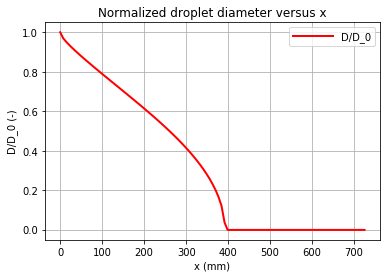

In [15]:
# plot the x evolution of droplet diameter, normalized by the initial droplet diameter, using data in "solution"
fig, ax = plt.subplots()
ax.plot(solution.t*1000., solution.y[0,:]/D_0, label='D/D_0', ls='solid', color='red', lw=2)
ax.set(xlabel='x (mm)',
       ylabel='D/D_0 (-)',
       title ='Normalized droplet diameter versus x')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("DoverD0_vs_x.pdf")

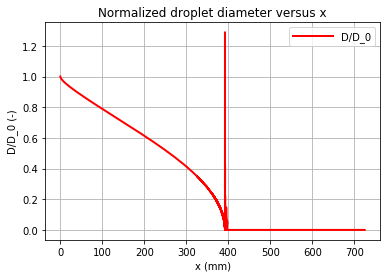

In [16]:
# plot the x evolution of droplet diameter, normalized by the initial droplet diameter, using data in "xDevelopment"
fig, ax = plt.subplots()
ax.plot(xDevelopment.index*1000., xDevelopment['D']/D_0, label='D/D_0', ls='solid', color='red', lw=2)
ax.set(xlabel='x (mm)',
       ylabel='D/D_0 (-)',
       title ='Normalized droplet diameter versus x')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("DoverD0_vs_x_2.pdf")

The two figures are essentially the same, other than the "spike" in the latter one at a point immediately before the droplets have fully vaporized. The spike can be seen in "xDevelopment" and not in "solution", because in "xDevelopment" we have stored data on each call to "Steady_1D_spray_combust", while in "solution" we have stored data only at intervals corresponding to properly converged solutions.

The results are very similar to those shown in Figure 10.19 of Turns 4th ed. for this value of the initial droplet diameter (50 micrometers). Here the vaporization appears to be a bit faster, for reaons that will be shown in subsequent figures.

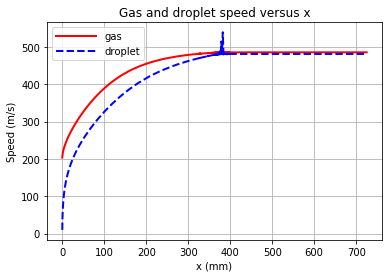

In [17]:
# plot the x evolution of gas speed and droplet speed
fig, ax = plt.subplots()
ax.plot(xDevelopment.index*1000., xDevelopment['v_g'], label='gas',     ls='solid',  color='red',  lw=2)
ax.plot(xDevelopment.index*1000., xDevelopment['v_d'], label='droplet', ls='dashed', color='blue', lw=2)
ax.set(xlabel='x (mm)',
       ylabel='Speed (m/s)',
       title ='Gas and droplet speed versus x')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("vg_vd_vs_x.pdf")

Again, there is an unphysical spike at a point immediately before the droplets have fully vaporized, because of the way that we chose to store the data. Aside from that, the results are similar to those shown in Figure 10.20 for this value of the initial droplet diameter (50 micrometers). The gas speed increases as a consequence of vaporization (higher gas mass flow rate) up to the point where all droplets have vaporized. The droplet speed starts at the prescribed initial value of 10 m/s, and increases as a consequence of drag until it is essentially equal to the gas speed. Again, droplet vaporization is somewhat faster here compared to the results shown in Chapter 10.

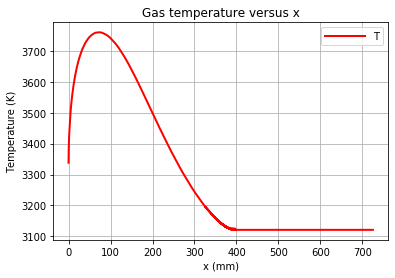

In [18]:
# plot the x evolution of gas temperature
fig, ax = plt.subplots()
ax.plot(xDevelopment.index*1000., xDevelopment['T_g'], label='T',     ls='solid',  color='red',  lw=2)
ax.set(xlabel='x (mm)',
       ylabel='Temperature (K)',
       title ='Gas temperature versus x')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Tg_vs_x.pdf")

The general shape of the curve is similar to that shown in Figure 10.19 of Turns 4th ed. for this value of the initial droplet diameter (50 micrometers). The temperature first increases with $x$ as the equivalence ratio increases through its stoichiometric value, then decreases as a consequence of the lower equilibrium temperature for the final very-fuel-rich mixture, in addition to the reduction in temperature as a consequence of the enthalpy required to vaporize the liquid fuel.

The temperatures are higher here compared to those shown in Figure 10. This is most likely a consequence of differences in thermodynamic property data used here versus there. Also, the equilibrium state that is computed here accounts for a larger set of species. It is presumably the higher gas temperatures computed here that are responsible for the faster vaporization.

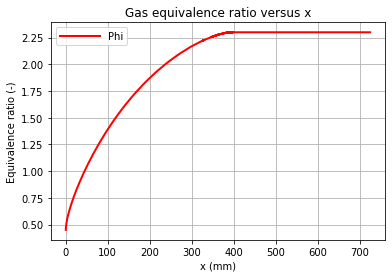

In [19]:
# plot the x evolution of gas equivalence ratio
fig, ax = plt.subplots()
ax.plot(xDevelopment.index*1000., xDevelopment['Phi_g'], label='Phi',     ls='solid',  color='red',  lw=2)
ax.set(xlabel='x (mm)',
       ylabel='Equivalence ratio (-)',
       title ='Gas equivalence ratio versus x')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Phigg_vs_x.pdf")

Again, the general shape of the curve is similar to that shown in Figure 10.19 of Turns 4th ed. for this value of the initial droplet diameter (50 micrometers). The gas-phase equivalence ratio is equal to 0.45 at x=0, the value that is given in the problem statement for the initial premixed fuel/oxidizer mixture. It then increases to a final value of 2.3 (the given overall equivalence ratio value) after all of the fuel has vaporized.

## 4. What's next

You can rerun the model for different values of the initial droplet diamter, and compare the results with those shown in Figures 10.19 and 10.20 of Turns Chapter 10. The present results are largely consistent with those shown in Chapter 10, with the exception of the someshat higher gas temperatures and the resulting faster vaporization rates here compared to there. An "elegant" way to do that would be to encapsulate this full model in a function, and to run that function for multiple values of the initial droplet diameter.

You can proceed similarly to perform parametric studies with variations in other physical parameters, to explore their influences: for example, different premixed and overall equivalence ratios, different initial temperatures and pressure, different fuel and/or oxidizer compositions, . . .